In [91]:
import geopandas as gpd
from shapely.geometry import Point
import geopy.distance
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
CRS = 'EPSG:4326'

In [3]:
cbg_polygon_gdf = gpd.read_file('./data/nyc_cbgs.geojson')
cbg_polygon_gdf = cbg_polygon_gdf.to_crs(CRS)
cbg_polygon_gdf = cbg_polygon_gdf.rename(columns={
    'CensusBlockGroup': 'cbg',
})
cbg_polygon_gdf['cbg'] = cbg_polygon_gdf['cbg'].astype(int)
cbg_polygon_gdf = cbg_polygon_gdf[['cbg', 'geometry']]

cbg_point_gdf = gpd.read_file('./data/nyc_cbg_centroids.geojson')
cbg_point_gdf = cbg_point_gdf.to_crs(CRS)
cbg_point_gdf = cbg_point_gdf.rename(columns={
    'CensusBlockGroup': 'cbg',
})
cbg_point_gdf['cbg'] = cbg_point_gdf['cbg'].astype(int)
cbg_point_gdf = cbg_point_gdf[['cbg', 'geometry']]

cbg_df = pd.read_csv('./data/cbg_attr_and_cluster_1021.csv')
cbg_df = cbg_df.rename(columns={
    'census_block_group': 'cbg',
    'Cluster': 'cluster',
    'Total Population': 'population',
})
cbg_df = cbg_df[['cbg', 'cluster', 'population']]
cbg_df['cluster'] = cbg_df['cluster'].astype('category')

cbg_polygon_gdf = cbg_polygon_gdf.merge(cbg_df, how='inner', on=['cbg'])
cbg_point_gdf = cbg_point_gdf.merge(cbg_df, how='inner', on=['cbg'])

In [4]:
def plot(polygon_gdf, point_gdf, SIZE=10):
    fig, ax = plt.subplots(figsize=(SIZE, SIZE))
    polygon_gdf.plot(ax=ax, color='#eee')
    point_gdf.plot(ax=ax, color='C0', markersize=1)
    plt.tight_layout()
    plt.show()

In [96]:
poi_df = pd.read_csv('./exports/poi.csv')
poi_gdf = gpd.GeoDataFrame(poi_df,
                           geometry=gpd.points_from_xy(poi_df['longitude'],
                                                       poi_df['latitude']),
                           crs='EPSG:4326')
poi_gdf = poi_gdf.to_crs(CRS)
poi_gdf = poi_gdf.fillna(0)

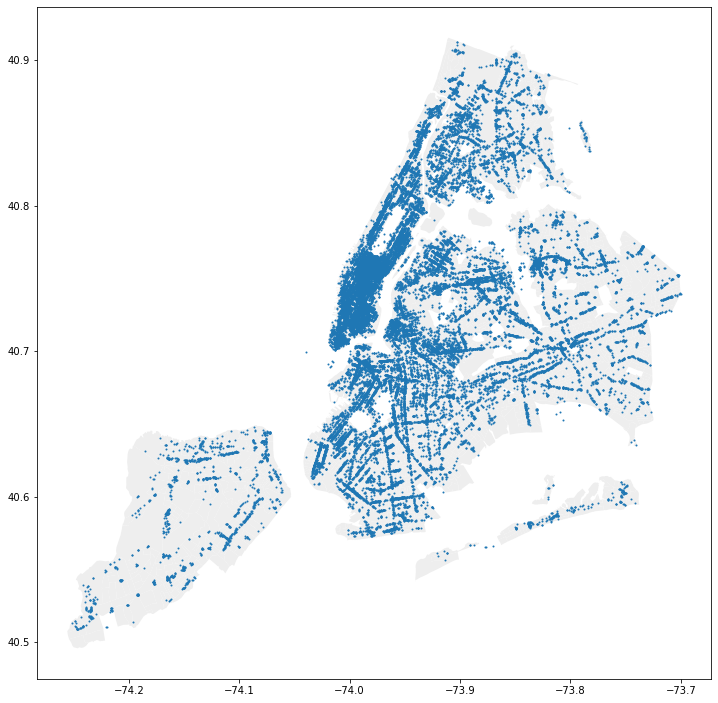

In [97]:
plot(cbg_polygon_gdf, poi_gdf)

In [98]:
# Precomputed CBG-CBG distances.
distance_df = pd.read_csv('./exports/cbg_distance_matrix_sorted.csv')
distance_df.head()
distance_df.index = distance_df['CensusBlockGroup']
distance_df = distance_df.drop(columns=['CensusBlockGroup'])
distance_df.columns = [int(col) for col in distance_df.columns]
distance_df.head()

In [134]:
categories = list(set(poi_gdf['category']))
categories.sort()
display(categories)

['Community and Special Food Services',
 'Food (Health) Supplement Stores',
 'General Merchandise and Convenience Stores',
 'Restaurants and Other Eating Places',
 'Supermarkets and Specialty Food Stores',
 'Tobacco and Liquor Stores']

In [135]:
# Lat/lon short-circuit distance for 1km.
THRESHOLD_1000 = 0.0001

def get_exact_area_proximity(p1, p2, r):
    # Short circuit using lat/lon squared distance before executing
    if (p1.x - p2.x)**2 + (p1.y - p2.y)**2 > THRESHOLD_1000:
        return 0
    gp1 = geopy.Point(latitude=p1.y, longitude=p1.x)
    gp2 = geopy.Point(latitude=p2.y, longitude=p2.x)
    
    # Use great-circle distance for speed.
    d = geopy.distance.great_circle(gp1, gp2).m

def get_area_proximity(cbg, poi_cbg, poi_area, r):
    # Use pre-computed CBG-CBG distance for speed.
    d = distance_df.loc[cbg, poi_cbg]
    
    # Return inverse-distance * POI area.
    return max(0, r - d) * poi_area

In [136]:
INDEX_CBG = 1
INDEX_AREA = 6
SEARCH_RADIUS_IN_M = 1000


def get_area_proximity_index(poi_gdf, cbg_point):
    return np.sum([
        get_area_proximity(cbg_point, row[1][INDEX_CBG], row[1][INDEX_AREA],
                           SEARCH_RADIUS_IN_M) for row in poi_gdf.iterrows()
    ])

In [139]:
tqdm.pandas()
for i, category in enumerate(categories):
    poi_cat_gdf = poi_gdf[poi_gdf['category'] == category].sample(frac=0.1)
    cbg_polygon_gdf[f'category_{i}_proximity_index'] = (
        cbg_point_gdf['cbg'].progress_apply(
            lambda x: get_area_proximity_index(poi_cat_gdf, x)))

100%|██████████| 6221/6221 [02:50<00:00, 36.41it/s]


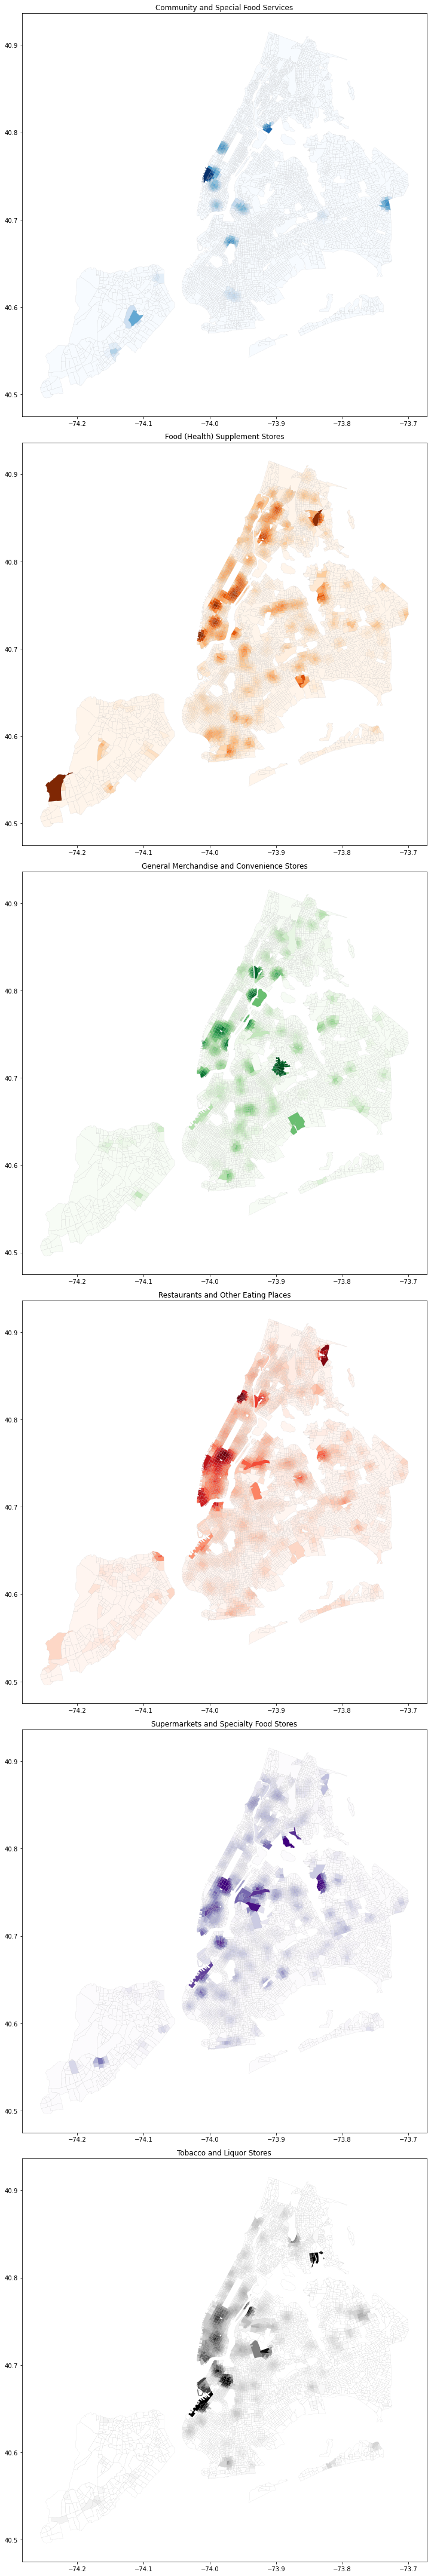

In [141]:
N_CAT = 6
cmaps = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples', 'Greys']

fig, ax = plt.subplots(N_CAT, 1, figsize=(10, 10 * N_CAT))
for i, category in enumerate(categories):
    cbg_polygon_gdf.plot(ax=ax[i],
                         column=f'category_{i}_proximity_index',
                         scheme='FisherJenksSampled',
                         cmap=cmaps[i],
                         edgecolor='#999',
                         linewidth=0.1,
                         k=20)
    ax[i].set_title(category)
plt.tight_layout()
plt.show()

In [142]:

cbg_polygon_gdf[['cbg'] + [f'category_{i}_proximity_index' for i in range(0, N_CAT)]].to_csv('./exports/proximity_index_sampled.csv', index=False)